In [22]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# Animals names dataset

# with open('../data/animals_names.txt', 'r') as file:
#     data = file.read()

# # Split the data into a list of names
# words = [name.lower() for name in data.split(',')]

# # Print the list to verify
# print(words[:10])

# for w in words:
#     if "'" in w or "-" in w or "(" in w or ")" in w:
#         words.remove(w)

In [24]:
# all_names_string = ''.join(words)

# # Create a set of unique characters
# unique_characters = set(all_names_string)

# # Print the unique characters
# print(unique_characters)

In [25]:
# People names dataset
words = open("../data/names.txt", 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [26]:
# Vocabulary
chars = [c for c in '.abcdefghijklmnopqrstuvwxyz']

# Convertion between characters and integers
itos = {i: c for i, c in enumerate(chars)}
stoi = {c: i for i, c in enumerate(chars)}

In [27]:
block_size = 3
def build_dataset(names):
    X, Y = [], []

    for name in names:
        c1 = [0] * block_size
        for ch in name + '.':
            X.append(c1)
            Y.append(stoi[ch])
            c1 = c1[1:] + [stoi[ch]]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

In [28]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [63]:
n_emb = 10 # dimension of embeddings
n_hidden = 200 # number of neurons on the hidden layer
vocab_size = len(chars) # size of the vocabulary

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),           generator=g)
W1 = torch.randn((n_emb*block_size, n_hidden), generator=g) * (5/3) / (n_emb*block_size) **0.5
# b1 = torch.randn((n_hidden),                   generator=g) * 0
W2 = torch.randn((n_hidden, vocab_size),       generator=g) * 0.1
b2 = torch.randn((vocab_size),                 generator=g) * 0

# BatchNorm parameters
bn_gain = torch.ones((1,n_hidden)) # batch normalization gain
bn_bias = torch.zeros((1,n_hidden)) # batch normalization bias
bn_mean_running = torch.zeros((1,n_hidden)) # running mean of the batch normalization
bn_std_running = torch.ones((1,n_hidden)) # running standard deviation of the batch normalization

parameters = [C, W1, W2, b2, bn_gain, bn_bias]

W2 and b2 should be lower values so that the initial probabilities of each character in the vocab is equal, resulting in a lower initial loss

W1 and b1 shoudl be lower so we dont get dead neurons due to tanh

In [64]:
# Number of parameters
print(sum(p.numel() for p in parameters), "parameters")
for p in parameters:
    p.requires_grad = True

12097 parameters


In [65]:
max_steps = 200000
batch_size = 32
losses = []

for i in range(max_steps):    
    
    #mini batch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    #Forward pass
    emb = C[Xb]

    # Linear Layer
    h_preact = emb.view(emb.shape[0], -1) @ W1 #+ b1  b1 is useless when you apply batch normalization

    # BactchNorm Layer
    bn_mean_i = h_preact.mean(0, keepdim=True)
    bn_std_i = h_preact.std(0, keepdim=True)
    h_preact = bn_gain*(h_preact - bn_mean_i) / bn_std_i + bn_bias

    with torch.no_grad():
        bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
        bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i


    # Non linearity
    hidden_state = torch.tanh(h_preact)
    logits = hidden_state @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data -= p.grad * lr

    losses.append(loss.log10().item())


KeyboardInterrupt: 

In [51]:
# calibrate the batch norm at the end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    h_preact = embcat @ W1 + b1
    bn_mean = h_preact.mean(0, keepdim=True)
    bn_std = h_preact.std(0, keepdim=True)

### Analyzing activations

(array([1189.,  265.,  186.,  129.,  118.,   92.,   90.,   75.,   66.,
          65.,   73.,   47.,   62.,   63.,   45.,   59.,   56.,   52.,
          47.,   54.,   41.,   50.,   59.,   55.,   59.,   73.,   59.,
          60.,   70.,   62.,   53.,   46.,   65.,   47.,   40.,   44.,
          50.,   56.,   70.,   64.,   66.,   81.,   76.,   88.,   90.,
         101.,  131.,  180.,  275., 1356.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <a list of 50 Patch objects>)

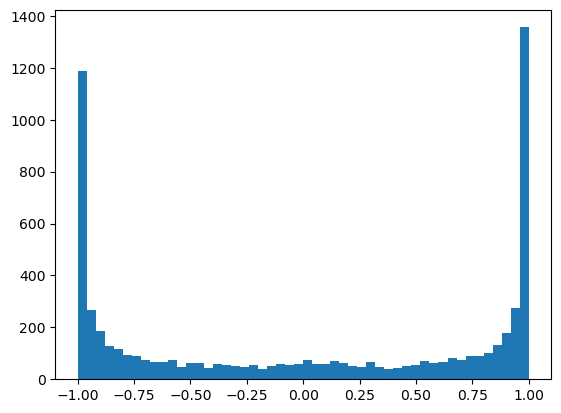

In [32]:
plt.hist(hidden_state.view(-1).tolist(), 50)

if the neurons have activations of -1 and 1 they will hardly have their gradients updated, because of the way backpropgation is calculated in tanh

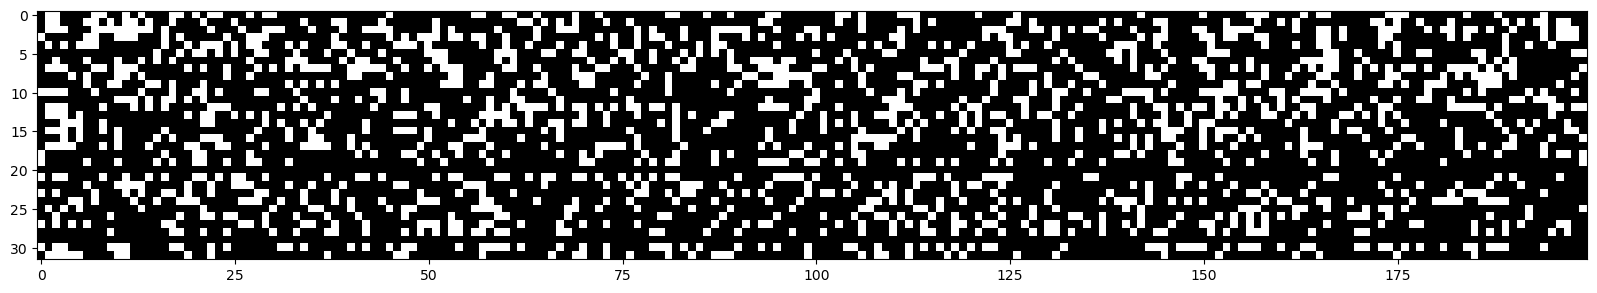

In [33]:
# If a column is all white it means a dead neuron
plt.figure(figsize=(20, 5))
plt.imshow(hidden_state.abs() > 0.99, cmap='gray', interpolation='nearest')

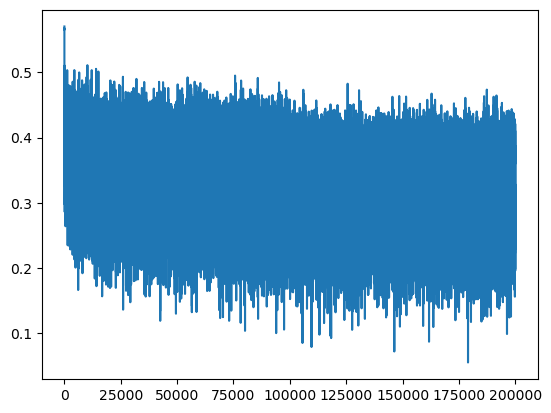

In [34]:
plt.plot(losses)

In [58]:
# Calculate loss on validation set
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    h_preact = emb.view(emb.shape[0], -1) @ W1 #+ b1
    # h_preact = bn_gain*(h_preact - h_preact.mean(0, keepdim=True)) / h_preact.std(0, keepdim=True) + bn_bias
    h_preact = bn_gain*(h_preact - bn_mean_running) / bn_std_running + bn_bias

    hidden_state = torch.tanh(h_preact)
    logits = hidden_state @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item()}')

split_loss('train')
split_loss('dev')

train loss: 2.0691773891448975
dev loss: 2.1074821949005127


In [59]:
g = torch.Generator().manual_seed(14)

for _ in range(15):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h_preact = emb.view(emb.shape[0], -1) @ W1 #+ b1
        h_preact = bn_gain*(h_preact - bn_mean) / bn_std + bn_bias

        h = torch.tanh(h_preact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, 1)
        ix = torch.multinomial(probs, 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join([itos[i] for i in out[:-1]]))

mowyn
cha
cresharlettarvikton
maierenessacelen
revoni
wellisamina
sey
trhelif
tigden
ansh
emeliyan
zuxiah
angeyosezadriel
han
evious
